# Flood - Analysis - Magnitude Regression
<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 06/23/2016 <br/>
</h3>

# Setup

In [1]:
script_name = 'flood_analysis_magnitude_regression'

In [2]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import flood_functions
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from IPython.display import display, HTML
from scipy import stats

In [3]:
print 'Matplotlib Styles:', '\n'.join(plt.style.available)

Matplotlib Styles: seaborn-darkgrid
seaborn-notebook
classic
seaborn-ticks
grayscale
bmh
seaborn-talk
dark_background
ggplot
fivethirtyeight
seaborn-colorblind
seaborn-deep
seaborn-whitegrid
seaborn-bright
seaborn-poster
seaborn-muted
seaborn-paper
seaborn-white
seaborn-pastel
seaborn-dark
seaborn-dark-palette


In [4]:
# plot settings

#%matplotlib
%pylab inline

plt.style.use('ggplot')
fig_large = (18,9.9)
fig_small = (9,4.45)

Populating the interactive namespace from numpy and matplotlib


In [5]:
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/' + script_name + '/'

# Load Data

## GRACE

In [6]:
# lowres grace features
f = open(dir_python_data + 'grace_features_lowres.p', 'rb')
feature_bricks = pickle.load(f)
f.close()

In [7]:
# lowres land mask
f = open(dir_python_data + 'grace_land_mask_lowres.p', 'rb')
land_mask = pickle.load(f)
f.close()

land_mask = np.flipud(land_mask.transpose())

## Flood Events

In [8]:
# lowres flood events
f = open(dir_python_data+'flood_event_brick_lowres.p', 'rb')
flood_brick = pickle.load(f)
f.close()

flood_brick = flood_brick[0]
flood_brick = np.flipud(flood_brick.transpose((1, 0, 2)))

## Modis Land Coverage

In [9]:
# lowres modis land coverage maps
f = open(dir_python_data + 'modis_mask_lowres_dict.p', 'rb')
modis_mask_dict = pickle.load(f)
f.close()

## CMAP Precipitation

In [64]:
# load pentad time data
f = open(dir_python_data + 'cmap_pentad_precip_time_dict.p', 'rb')
cmap_pentad_precip_time_dict = pickle.load(f)
f.close()

# load monthly time data
f = open(dir_python_data + 'cmap_monthly_precip_time_dict.p', 'rb')
cmap_monthly_precip_time_dict = pickle.load(f)
f.close()

print cmap_pentad_precip_time_dict.keys()
print cmap_monthly_precip_time_dict.keys()

['cmap_precip_time_date_pentad', 'cmap_precip_time_str_pentad']
['cmap_precip_time_date_monthly', 'cmap_precip_time_str_monthly']


## Flood Observatory

In [10]:
df_name = 'df_flood_grace_time_location_features'

In [11]:
df_flood_grace = pd.read_csv(dir_python_data + df_name + '.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)

print "Dataframe Size:",df_flood_grace.shape
print "Dataframe Columns:"
print '\n'.join(df_flood_grace.columns.values)
df_flood_grace.head(1)

Dataframe Size: (1070, 76)
Dataframe Columns:
Register #
Began
Date Began
Ended
Duration in Days
Dead
Displaced
Main cause
Severity *
Affected sq km
Magnitude (M)**
Country
Other
Centroid X
Centroid Y
Centroid GRACE Lon
Centroid GRACE Lat
Prior CMAP Precip Diff-Days Monthly
Prior CMAP Precip Index Monthly
Prior CMAP Precip Diff-Days Pentad
Prior CMAP Precip Index Pentad
Prior MASCON Diff-Days
Prior MASCON Index
Post MASCON Diff-Days
Post MASCON Index
GRACE lwe
GRACE lwe norm
GRACE lwe clim
GRACE lwe clim norm
GRACE lwe noClim
GRACE lwe noClim norm
GRACE lwe dt
GRACE lwe dt norm
GRACE lwe post
GRACE lwe norm post
GRACE lwe clim norm post
GRACE lwe noClim norm post
GRACE lwe rank
GRACE lwe rank norm
GRACE lwe clim rank
GRACE lwe clim rank norm
GRACE lwe noClim rank
GRACE lwe noClim rank norm
GRACE lwe rank post
GRACE lwe rank norm post
GRACE lwe clim rank post
GRACE lwe clim rank norm post
GRACE lwe noClim rank post
GRACE lwe noClim rank norm post
modis_coastal
modis_grasslands
modis_urb

,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,...,modis_woody_savannas,modis_snow_ice,modis_deciduous_needleleaf_forest,modis_all,modis_all_named,modis_grace,CMAP precip pentad,CMAP precip pentad norm,CMAP precip monthly,CMAP precip monthly norm
0,4256.0,11-May-15,11-May-15,21-May-15,11.0,0.0,1776.0,Torrential Rain,1.0,32595.44,...,0.0,0.0,0.0,16.0,Barren or Sparsely Vegetted,Non-Absorbing Land Cover,0.72,0.535318,0.56,0.054842


# Define Script Variables

In [12]:
tp = flood_brick.shape[2]
df = df_flood_grace

# Alter Flood Dataframe

## Add CMAP Log Column

In [89]:
### TROUBLE SHOOTING ###

time_str = cmap_monthly_precip_time_dict['cmap_precip_time_str_monthly']
time_str = cmap_monthly_precip_time_dict['cmap_precip_time_str_monthly']



print time_str[118]
#print min(df['Centroid X'])
#print min(df['Centroid Y'])

df[['modis_all_named', 'Main cause', 'Centroid X', 'Centroid Y', 'Date Began', \
    'Prior CMAP Precip Diff-Days Monthly', 'Prior CMAP Precip Index Monthly', \
    'CMAP precip pentad', 'CMAP precip monthly']]\
.loc[df['CMAP precip monthly'] == 0]




2012-01-31


,modis_all_named,Main cause,Centroid X,Centroid Y,Date Began,Prior CMAP Precip Diff-Days Monthly,Prior CMAP Precip Index Monthly,CMAP precip pentad,CMAP precip monthly
140,Cropland/Natural Vegetation Mosaic,Heavy Rain,12.8074,9.85967,20-Feb-12,20.0,118.0,0.00,0.0
159,Snow and Ice,Monsoonal Rain,71.7428,38.27790,25-Aug-11,25.0,112.0,0.41,0.0
494,Evergreen Broadleaf Forest,Heavy rain,-10.5823,6.50598,26-Aug-07,26.0,64.0,1.04,0.0
562,Barren or Sparsely Vegetted,Heavy rain,49.1341,16.57230,23-Mar-07,23.0,59.0,0.00,0.0


''' 
df['CMAP precip monthly log'] = np.log10(df['CMAP precip monthly'])

print df['CMAP precip monthly'].min()
print df['CMAP precip monthly'].argmin()

print df['CMAP precip monthly log'].min()
print df['CMAP precip monthly log'].argmin()


print df['CMAP precip monthly log'].iloc[140]
print df['CMAP precip monthly log'].iloc[152]

#print np.log10(0)

'''

## Add GRACE DT Fill Column

In [13]:
# GRACE Derivative  column with NaN's replaced with average value
df['GRACE lwe dt norm fill'] = df['GRACE lwe dt norm']
df.loc[np.isnan(df['GRACE lwe dt norm']), 'GRACE lwe dt norm fill'] = \
    np.nanmean(df['GRACE lwe dt norm'])
df[['GRACE lwe dt norm', 'GRACE lwe dt norm fill']].loc[np.isnan(df['GRACE lwe dt norm'])]

,GRACE lwe dt norm,GRACE lwe dt norm fill
1048,NaN,0.5047
1050,NaN,0.5047
1060,NaN,0.5047
1061,NaN,0.5047
1062,NaN,0.5047
1063,NaN,0.5047
1064,NaN,0.5047
1065,NaN,0.5047
1066,NaN,0.5047
1067,NaN,0.5047


## Correct Magnitude Value

In [14]:
# Correct Regsiter 3499
df2 = df.copy()

# index value for register 3499
idx = 325 # refer to output of cell to define idx number


# show inccorect value of zero
print 'Incorrect Value:'
print df2[['Register #','Magnitude (M)**','Severity *','Affected sq km','Duration in Days']]\
        .loc[df['Register #'] == 3499]

# change from 0 to 6.0
df.set_value(col='Magnitude (M)**', index=idx, value=6.0)
print '\n' + 'Correct Value:'
print df[['Register #','Magnitude (M)**','Severity *','Affected sq km','Duration in Days']]\
        .loc[df['Register #'] == 3499]

Incorrect Value:
     Register #  Magnitude (M)**  Severity *  Affected sq km  Duration in Days
325      3499.0              0.0         1.0        55064.21              17.0

Correct Value:
     Register #  Magnitude (M)**  Severity *  Affected sq km  Duration in Days
325      3499.0              6.0         1.0        55064.21              17.0


## Create Absorbing Land Coverage Dataframe

In [15]:
df_absorb = df.copy()
df_absorb = df_absorb[df['modis_grace']=='Absorbing Land Cover']
df_absorb.head(1)
print df_absorb.shape

(780, 77)


# Analysis

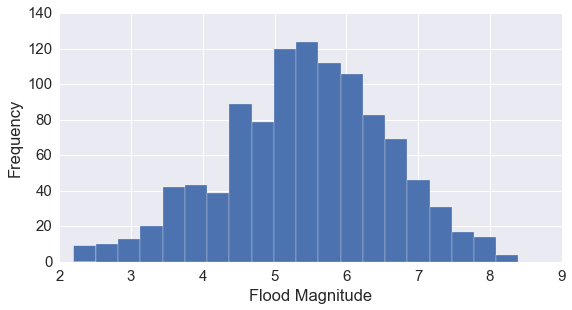

In [96]:
# flood magnitude histogram
plt.figure(figsize=fig_small)

df['Magnitude (M)**'].plot.hist(bins=20)
plt.xlabel('Flood Magnitude')

plt.show()

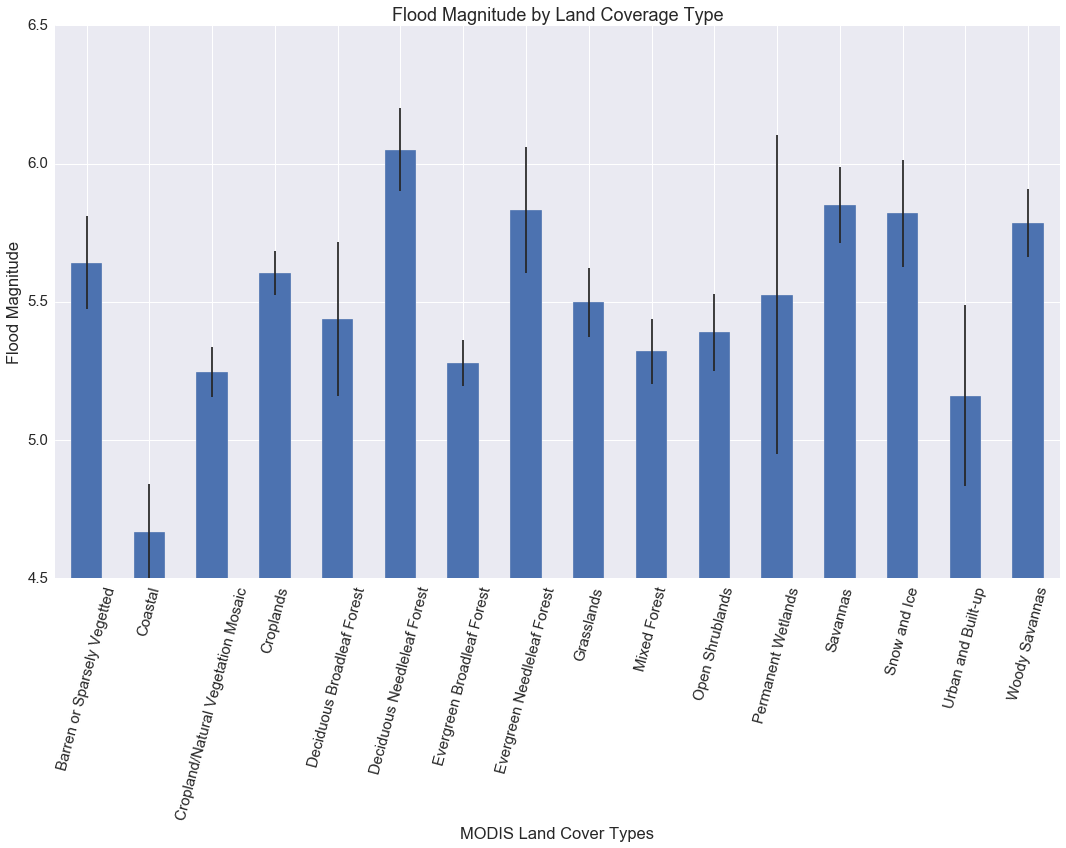

In [97]:
# plot flood magnitude and land cover types
grp = df['Magnitude (M)**'].groupby(df['modis_all_named'])

# caclualte means and errors
means = grp.mean()
errors = grp.std() / sqrt(grp.size())

# sort

# plot
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=fig_large)
means.plot.bar(yerr=errors, ax=ax, sort_columns=True)
plt.ylim((4.5,6.5))
plt.xticks(rotation=75)

plt.xlabel('MODIS Land Cover Types')
plt.ylabel('Flood Magnitude')
plt.title('Flood Magnitude by Land Coverage Type')


plt.show()

## Multivariate Regression

In [98]:
# remove spaces from columns being used in multi-variate regression
df['Magnitude'] = df['Magnitude (M)**']
df['GRACE_lwe_norm'] = df['GRACE lwe norm']
df['GRACE_lwe_clim_norm'] = df['GRACE lwe clim norm']
df['GRACE_lwe_noClim_norm'] = df['GRACE lwe noClim norm']  
df['GRACE_lwe_dt_norm_fill'] = df['GRACE lwe dt norm fill']  
df['CMAP_precip_pentad_norm'] = df['CMAP precip pentad norm'] 
df['CMAP_precip_monthly_norm'] = df['CMAP precip monthly norm'] 

df_absorb['Magnitude'] = df_absorb['Magnitude (M)**']
df_absorb['GRACE_lwe_norm'] = df_absorb['GRACE lwe norm']
df_absorb['GRACE_lwe_clim_norm'] = df_absorb['GRACE lwe clim norm']
df_absorb['GRACE_lwe_noClim_norm'] = df_absorb['GRACE lwe noClim norm']  
df_absorb['GRACE_lwe_dt_norm_fill'] = df_absorb['GRACE lwe dt norm fill']  
df_absorb['CMAP_precip_pentad_norm'] = df_absorb['CMAP precip pentad norm'] 
df_absorb['CMAP_precip_monthly_norm'] = df_absorb['CMAP precip monthly norm'] 

### Formulas

In [102]:
# FOR PRESENTATION
est = smf.ols(formula="Magnitude ~ " + 
              "GRACE_lwe_clim_norm +" +
              "GRACE_lwe_noClim_norm +" +
              "GRACE_lwe_dt_norm_fill +" +
              "C(modis_all_named) ",
              data=df_absorb).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Magnitude   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     5.523
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           4.21e-09
Time:                        10:53:11   Log-Likelihood:                -1173.3
No. Observations:                 780   AIC:                             2373.
Df Residuals:                     767   BIC:                             2433.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    4.6297      0.188     24.565      0.000         4.260     5.000
C(modis_all_named)[T.Cropland/Natural Vegetation Mosaic]     0.5041      0.211      2.393      0.017         0.091     0.918
C(modis_all_named)[T.Croplands]                              0.8416      0.207      4.071      0.000         0.436     1.247
C(modis_all_named)[T.Deciduous Broadleaf Forest]             0.7306      0.315      2.321      0.021         0.113     1.348
C(modis_all_named)[T.Deciduous Needleleaf Forest]            1.1328      0.805      1.407      0.160        -0.448     2.713
C(modis_all_named)[T.Evergreen Broadleaf Forest]             0.5135      0.206      2.497      0.013         0.110     0.917
C(modis_all_named)[T.Evergreen Needleleaf Forest]            1.1607      0.333      3.483      0.001         0.507     1.815
C(modis_all_named)[T.Grasslands]                             0.7255      0.216      3.356      0.001         0.301     1.150
C(modis_all_named)[T.Mixed Forest]                           0.5594      0.220      2.543      0.011         0.128     0.991
C(modis_all_named)[T.Permanent Wetlands]                     0.8655      0.581      1.491      0.136        -0.274     2.005
GRACE_lwe_clim_norm                                          0.1645      0.041      4.015      0.000         0.084     0.245
GRACE_lwe_noClim_norm                                        0.0915      0.044      2.087      0.037         0.005     0.178
GRACE_lwe_dt_norm_fill                                       0.1000      0.044      2.274      0.023         0.014     0.186
==============================================================================
Omnibus:                        4.831   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.669
Skew:                          -0.174   Prob(JB):                       0.0968
Kurtosis:                       3.152   Cond. No.                         30.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# (0)
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_monthly_norm",
              data=df).fit()
est.summary()

In [95]:
# (1) model: test land cover types
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_monthly_norm *" +
              "C(modis_all_named)",
              data=df).fit()
est.summary()

NameError: name 'Magnitude' is not defined

In [ ]:
# (1a)
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_monthly_norm +" +
              "C(modis_all_named) +" +
              "GRACE_lwe_clim_norm +" +
              "GRACE_lwe_noClim_norm +" +
              "GRACE_lwe_dt_norm_fill",
              data=df).fit()
est.summary()

In [ ]:
# (2) model: precip + land cover types
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_pentad_norm +" +
              "modis_coastal +" +
              "modis_cropland_natural_vegetation +" +
              "modis_evergreen_broadleaf_forest +" +
              "modis_mixed_forest",
              data=df).fit()
est.summary()

In [ ]:
# (3) model:  precip & land cover type interaction
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_pentad_norm +" +
              "modis_coastal +" +
              "modis_cropland_natural_vegetation +" +
              "modis_evergreen_broadleaf_forest +" +
              "modis_mixed_forest +" +
              "CMAP_precip_pentad_norm : modis_coastal +" +
              "CMAP_precip_pentad_norm : modis_cropland_natural_vegetation +" +
              "CMAP_precip_pentad_norm : modis_evergreen_broadleaf_forest +" +
              "CMAP_precip_pentad_norm : modis_mixed_forest ",
              data=df).fit()
est.summary()

In [ ]:
# (4) model: grace + precip + land cover types
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_pentad_norm +" +
              "GRACE_lwe_clim_norm +" +
              "GRACE_lwe_noClim_norm +" +
              "GRACE_lwe_dt_norm_fill +" +
              "modis_coastal +" +
              "modis_cropland_natural_vegetation +" +
              "modis_evergreen_broadleaf_forest +" +
              "modis_mixed_forest",
              data=df).fit()
est.summary()

In [ ]:
# (5) model: grace + precip + grace : precip + land cover types in absorbing land-types
est = smf.ols(formula="Magnitude ~ " + 
              "CMAP_precip_pentad_norm +" +
              "GRACE_lwe_clim_norm +" +
              "GRACE_lwe_noClim_norm +" +
              "GRACE_lwe_dt_norm_fill +" +
              "modis_coastal +" +
              "modis_cropland_natural_vegetation +" +
              "modis_evergreen_broadleaf_forest +" +
              "modis_mixed_forest",
              data=df_absorb).fit()
est.summary()

## Land Coverage Grouping

In [ ]:
x_col_name = 'GRACE lwe norm'
y_col_name = 'Magnitude (M)**'
title = 'GRACE & Flood Magnitude\n Absorbing vs. Non-Absorbing Land Coverage'

sns.set(font_scale=1.5)
sns_plot = sns.lmplot(x=x_col_name, y=y_col_name, hue='modis_grace', data=df,
                      size=6, aspect=2)
plt.title(title)
plt.show()

# save figure
sns_plot.savefig(dir_figures + 'modisAbsorbingHue_regression_' + x_col_name + '_' + y_col_name \
    + '.pdf', bbox_inches='tight')

In [ ]:
x_col_name = 'GRACE lwe noClim norm'
y_col_name = 'Magnitude (M)**'
title = 'GRACE Anomaly & Flood Magnitude\n Absorbing vs. Non-Absorbing Land Coverage'

sns.set(font_scale=1.5)
sns_plot = sns.lmplot(x=x_col_name, y=y_col_name, hue='modis_grace', data=df,
                      size=6, aspect=2)
plt.title(title)
plt.show()

# save figure
sns_plot.savefig(dir_figures + 'modisAbsorbingHue_regression_' + x_col_name + '_' + y_col_name \
    + '.pdf', bbox_inches='tight')

In [ ]:
x_col_name = 'GRACE lwe norm'
y_col_name = 'Magnitude (M)**'
title = 'GRACE & Flood Magnitude by Land Cover Type'
data = df

sns.set(font_scale=1)
sns_plot = sns.lmplot(x=x_col_name, y=y_col_name, col='modis_all_named', data=data,
           col_wrap=4, size=3, aspect=1.5, sharey=False, sharex=False)
plt.show()

# save figure
sns_plot.savefig(dir_figures + 'modisLandGroup_regression_' + x_col_name + '_' + y_col_name \
    + '.pdf', bbox_inches='tight')

In [ ]:
x_col_name = 'CMAP precip monthly norm'
y_col_name = 'Magnitude (M)**'
title = 'GRACE & Flood Magnitude by Land Cover Type'
data = df

sns.set(font_scale=1)
sns_plot = sns.lmplot(x=x_col_name, y=y_col_name, col='modis_all_named', data=data,
           col_wrap=4, size=3, aspect=1.5, sharey=False, sharex=False)
plt.show()

# save figure
sns_plot.savefig(dir_figures + 'modisLandGroup_regression_' + x_col_name + '_' + y_col_name \
    + '.pdf', bbox_inches='tight')

## Single Regression

In [16]:
# performs linear regression, outputs plot and statistics
def regression(df, x_col_name, y_col_name, title, color=None, xlim=None, kind='reg'):

    sns.set(font_scale=1.5)
    
    # define data
    x = df[x_col_name]
    y = df[y_col_name]

    # calculate x-raange
    x_max = x.max()
    x_min = x.min()

    # use seaborn to visulize regression
    sns_plot = sns.jointplot(x=x_col_name ,y=y_col_name, data=df, kind=kind,
             size=10, color=color, xlim=xlim, space=0.3)
    plt.title(title)
    plt.show()
    
    # save figure
    sns_plot.savefig(dir_figures + 'regression_' + x_col_name + '_' + y_col_name + '.png',
                bbox_inches='tight')

    # fitted line: y ~ c + x
    x = sm.add_constant(x) # add intercept term
    model = sm.OLS(y,x) # create model
    fitted = model.fit() # fit model

    # print fitted line results
    print(fitted.params)
    print(fitted.summary())

### Absorbing Land Cover Types

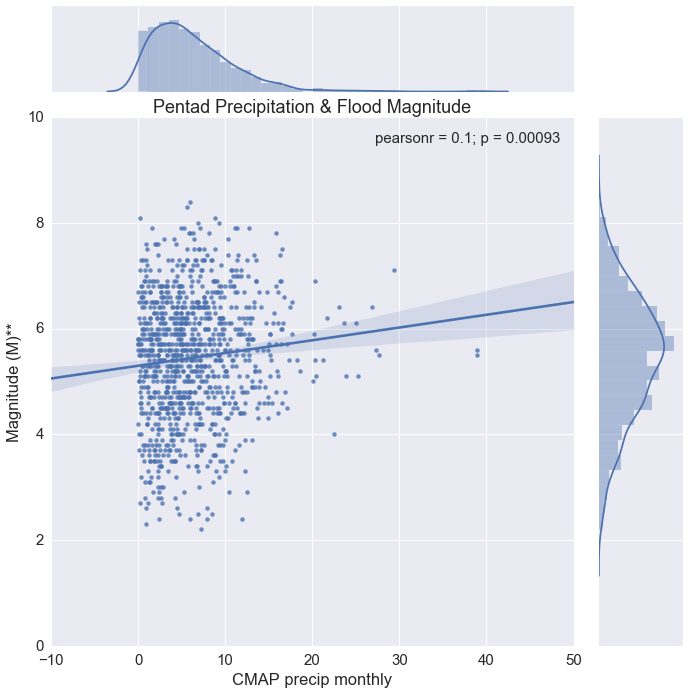

const                  5.296356
CMAP precip monthly    0.024121
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Magnitude (M)**   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.01
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           0.000934
Time:                        07:58:16   Log-Likelihood:                -1663.5
No. Observations:                1070   AIC:                             3331.
Df Residuals:                    1068   BIC:                             3341.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------

In [49]:
regression(df=df, 
           x_col_name='CMAP precip monthly', 
           y_col_name='Magnitude (M)**',
           title= 'Pentad Precipitation & Flood Magnitude',
           kind='reg')

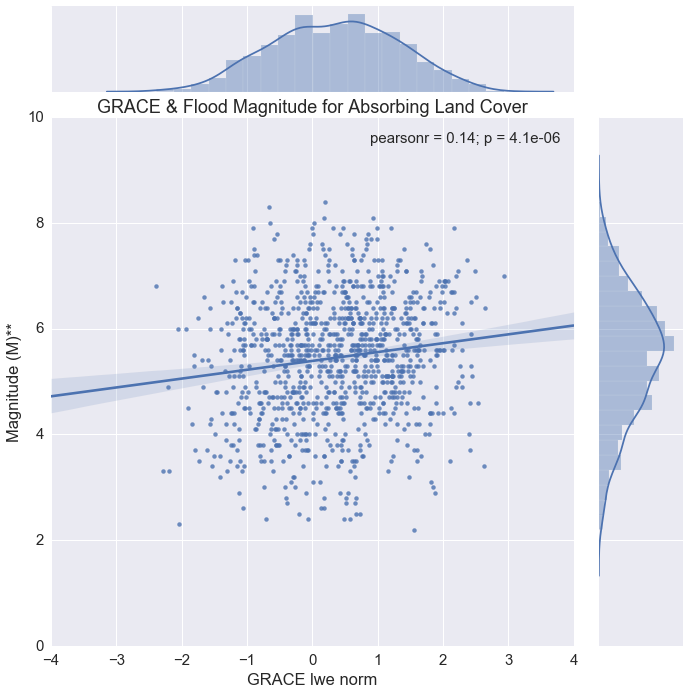

const             5.389612
GRACE lwe norm    0.167405
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Magnitude (M)**   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     21.43
Date:                Wed, 10 Aug 2016   Prob (F-statistic):           4.13e-06
Time:                        09:47:35   Log-Likelihood:                -1658.3
No. Observations:                1070   AIC:                             3321.
Df Residuals:                    1068   BIC:                             3331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

In [93]:
regression(df=df, 
           x_col_name='GRACE lwe norm', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE & Flood Magnitude for Absorbing Land Cover',
           color=None,
           xlim=(-4,4),
           kind='reg')

In [ ]:
regression(df=df_absorb, 
           x_col_name='GRACE lwe clim norm', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE Climatology & Flood Magnitude for Absorbing Land Cover',
           color='green',
           xlim=(-4,4),
           kind='reg')

In [ ]:
regression(df=df_absorb, 
           x_col_name='GRACE lwe noClim norm', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE Climatological Anomaly & Flood Magnitude for Absorbing Land Cover',
           color='red',
           xlim=(-4,4))
           

In [ ]:
regression(df=df_absorb, 
           x_col_name='GRACE lwe dt norm fill', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE Derivative & Flood Magnitude for Absorbing Land Cover',
           color='orange',
           xlim=(-4,4),
           kind='reg')

### All Floods

In [ ]:
regression(df=df, 
           x_col_name='CMAP precip penta norm', 
           y_col_name='Magnitude (M)**',
           title= 'Precipitation & Flood Magnitude',
           xlim=(-4,15), 
           kind='reg')

In [ ]:
regression(df=df, 
           x_col_name='GRACE lwe norm', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE & Flood Magnitude',
           color='steelblue',
           xlim=(-4,4),        
           kind='reg')

In [ ]:
df['random'] = np.random.randn(df.shape[0])
regression(df=df, 
           x_col_name='GRACE lwe clim norm', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE Climatology & Flood Magnitude',
           color='darkseagreen',
           xlim=(-4,4))

In [ ]:
df['random'] = np.random.randn(df.shape[0])
regression(df=df, 
           x_col_name='GRACE lwe noClim norm', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE Climatological Anomaly & Flood Magnitude',
           color='lightcoral',
           xlim=(-4,4),
           kind='reg')

In [ ]:
regression(df=df, 
           x_col_name='GRACE lwe dt norm fill', 
           y_col_name='Magnitude (M)**',
           title= 'GRACE Derivative & Flood Magnitude',
           color='darkorange',
           xlim=(-4,4))

In [ ]:
df['random'] = np.random.randn(df.shape[0])
regression(df=df, 
           x_col_name='random', 
           y_col_name='Magnitude (M)**',
           title= 'Random Values & Flood Magnitude',
           color='grey',
           xlim=(-4,4))